# Build a varitaional quantum circuit in Qiskit
as opposed to the pre-built algorithms like VQE

In [1]:
import numpy as np
from scipy.optimize import minimize
import qiskit
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from matplotlib import pyplot as plt

In [2]:
from qiskit_machine_learning.neural_networks import CircuitQNN

In [3]:
L = 6
thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters

In [4]:
def prepare_circuit(thetas):
    qreg = qiskit.QuantumRegister(L, 'q')
    creg = qiskit.ClassicalRegister(2, 'c')
    circ = qiskit.QuantumCircuit(qreg, creg)
    for i,t in enumerate(thetas[:L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,3)
    circ.cz(5,1)
    circ.cz(4,2)
    circ.cz(4,0)
    for i,t in enumerate(thetas[L:2*L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,2)
    circ.cz(4,3)
    circ.cz(5,0)
    circ.cz(4,1)
    circ.ry(thetas[2*L], 4)
    circ.ry(thetas[2*L+1], 5)
    circ.measure(qreg[4], creg[0])
    circ.measure(qreg[5], creg[1])
    return circ

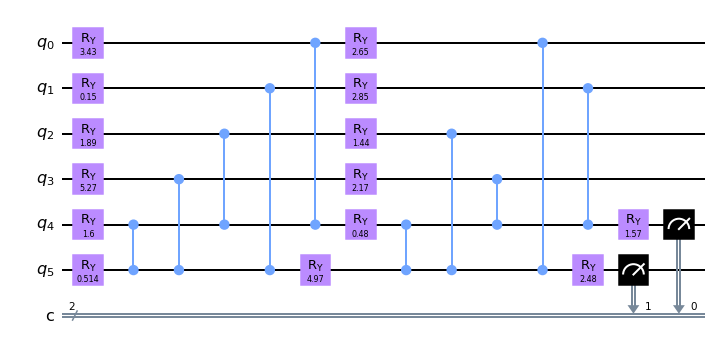

In [5]:
circ = prepare_circuit(thetas)
circ.draw('mpl') # trash qubits are at the bottom

In [6]:
num_trash = 2
entangler_map2 = [(5,4),(5,2),(4,3),(5,0),(4,1)]
entangler_map1 = [(5,4),(5,3),(5,1),(4,2),(4,0)]

In [63]:
asd = np.arange(3)
asd

array([0, 1, 2])

In [64]:
from sympy.utilities.iterables import multiset_permutations

In [66]:
list(multiset_permutations(asd))

[[0, 1, 2], [0, 2, 1], [1, 0, 2], [1, 2, 0], [2, 0, 1], [2, 1, 0]]

In [75]:
import itertools
list(itertools.permutations([0,1]))

[(0, 1), (1, 0)]

In [96]:
def get_entangler_map(L, num_trash, i_permut=0):
    result = []
    nums = np.arange(L)
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    permutations = list(itertools.permutations(nums_trash))
    for _,trash_q in enumerate(permutations[i_permut]):
        for comp_q in nums_compressed[_%num_trash::num_trash]: # combine each trash_q with even or odd site
            result.append((trash_q, comp_q))
    return result

In [97]:
get_entangler_map(6,4)

[(3, 2), (4, 3), (5, 4), (2, 0), (3, 1)]

In [126]:
entanglement = list([get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)])

In [127]:
num_trash = 2
entangler_map2 = [(5,4),(5,0),(5,2),(4,1),(4,3)]
entangler_map1 = [(5,4),(4,0),(4,2),(5,1),(5,3)]

In [128]:
[entangler_map1,entangler_map2]

[[(5, 4), (4, 0), (4, 2), (5, 1), (5, 3)],
 [(5, 4), (5, 0), (5, 2), (4, 1), (4, 3)]]

In [129]:
entanglement

[[(5, 4), (4, 0), (4, 2), (5, 1), (5, 3)],
 [(5, 4), (5, 0), (5, 2), (4, 1), (4, 3)]]

In [130]:
[entangler_map1,entangler_map2] == entanglement

True

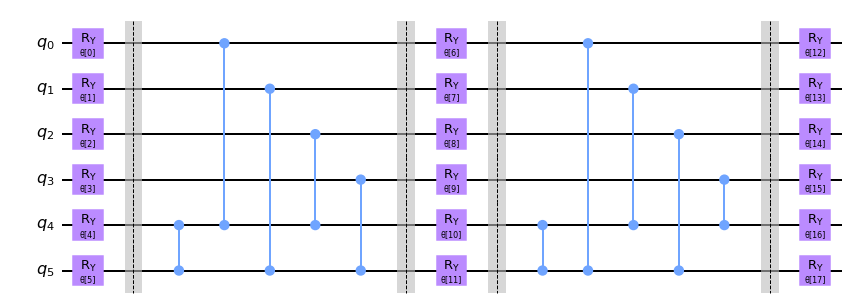

In [131]:
ansatz = qiskit.circuit.library.TwoLocal(L,"ry","cz",[entangler_map1,entangler_map2],reps=2, insert_barriers=True)
ansatz.draw("mpl")

In [132]:
all(isinstance(e3, (tuple, list)) for e in entanglement for e2 in e for e3 in e2)

False

In [133]:
entanglement2 = [entangler_map1,entangler_map2]

In [134]:
all(isinstance(e3, (tuple, list)) for e in entanglement2 for e2 in e for e3 in e2)

False

In [135]:
ansatz = qiskit.circuit.library.TwoLocal(L,"ry","cz",entanglement,reps=2, insert_barriers=True)
ansatz.draw("mpl")

ValueError: Invalid value of entanglement: [[(5, 4), (4, 0), (4, 2), (5, 1), (5, 3)], [(5, 4), (5, 0), (5, 2), (4, 1), (4, 3)]]

In [120]:
entanglement == [entangler_map1,entangler_map2]

True

In [121]:
# pretty sure this is a bug! Im gonna post it on github

In [88]:
def QAE_Ansatz(L,num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    print(entanglement)
    return qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                          )

[qiskit.circuit.library.TwoLocal(..) documentation](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html?highlight=twolocal#qiskit.circuit.library.TwoLocal)

<ipython-input-7-f84f215768ff>:13: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ2 = ansatz + measurement_circ
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


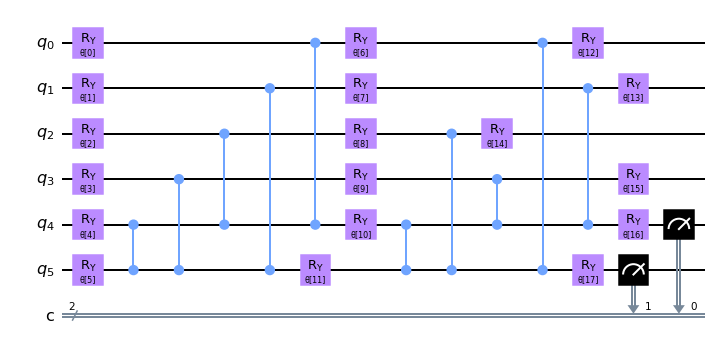

In [7]:
# Use Qiskit layer generator thingy because now it has everything it needs to get a gradient!
# Note that it has redundant Ry rotations at the end on the compression qubits, didnt find a clever way how to get rid of them, but this shouldnt change too much

# variational ansatz sub-circuit
ansatz = qiskit.circuit.library.TwoLocal(L,"ry","cz",[entangler_map1,entangler_map2],reps=2, insert_barriers=False)

# measurement circuit
qreg = qiskit.QuantumRegister(L, 'q')
creg = qiskit.ClassicalRegister(2, 'c')
measurement_circ = qiskit.QuantumCircuit(qreg, creg)
measurement_circ.measure(qreg[4], creg[0])
measurement_circ.measure(qreg[5], creg[1])
circ2 = ansatz + measurement_circ
circ2.decompose()
#print(circ2)
#measurement_circ.draw("mpl")
circ2.draw("mpl")

In [8]:
circ.parameters

ParameterView([])

In [9]:
circ2.parameters

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17])])

following [this tutorial on quantum neural networks](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html)

In [10]:
qi_qasm = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=10)
qi_sv = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [11]:
qnn4 = CircuitQNN(circ2, [], circ2.parameters, sparse=False, quantum_instance=qi_qasm)

In [12]:
input4 = np.random.rand(qnn4.num_inputs)
weights4 = np.random.rand(qnn4.num_weights)

In [13]:
qnn4.forward(input4, weights4)

array([[0.3, 0.2, 0.3, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [14]:
qnn4.backward(input4, weights4)

(array([], shape=(1, 64, 0), dtype=float64),
 array([[[0.  , 0.05, 0.1 , ..., 0.  , 0.05, 0.05],
         [0.1 , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [0.  , 0.05, 0.  , ..., 0.  , 0.  , 0.05],
         ...,
         [0.  , 0.  , 0.  , ..., 0.  , 0.05, 0.  ],
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.05]]]))

## further insight
"As the qasm_simulator has shot noise we choose to use SPSA which is designed to perform under noisy conditions." in this [variational quantum classifier tutorial](https://qiskit.org/documentation/tutorials/machine_learning/03_vqc.html)  
has a cost function optimization "by hand" at the end [link](https://qiskit.org/textbook/ch-paper-implementations/vqls.html)

# Build Variational algorithm from this

In [16]:
from qiskit.algorithms.variational_algorithm import VariationalAlgorithm

In [23]:
VariationalAlgorithm(ansatz = circ2, optimizer = None)